In [0]:
#to access kaggle datasets
# !pip install kaggle

#math operation
# !pip install numpy==1.15.0

#Machine Learning
!pip install catboost


In [0]:
#data preprocessing
import pandas as pd
#math operation
import numpy as np

#machine learning
from catboost import CatBoostRegressor,Pool

#data scaling
from sklearn.preprocessing import StandardScaler

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#support vector machine model
from sklearn.svm import NuSVR,SVR

#kernel ridge model
from sklearn.kernel_ridge import KernelRidge

#data visualization
import matplotlib.pyplot as plt


# **Import Dataset From Kaggle**

In [0]:
from google.colab import files

#retirve upploaded file
uploaded=files.upload()

#then move kaggle.json into the folderwhere the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2524           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9899            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4093           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2381           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 53.7MB/s]
 96% 233M/242M [00:01<00:00, 158MB/s]
100% 242M/242M [00:01<00:00, 139MB/s]
100% 2.02G/2.03G [00:16<00:00, 152MB/s]
100% 2.03G/2.03G [00:17<00:00, 127MB/s]


In [0]:
#unzip training data for usage

!ls

 catboost_info		 seg_42648c.csv   seg_8456d3.csv   seg_c20c06.csv
'kaggle (1).json'	 seg_4280d9.csv   seg_845a2a.csv   seg_c21723.csv
 sample_data		 seg_428d66.csv   seg_8472f3.csv   seg_c21d60.csv
 sample_submission.csv	 seg_42c4c9.csv   seg_848695.csv   seg_c22bd4.csv
 seg_00030f.csv		 seg_42e7e8.csv   seg_84a65d.csv   seg_c23429.csv
 seg_0012b5.csv		 seg_42ff14.csv   seg_84b9d9.csv   seg_c23641.csv
 seg_00184e.csv		 seg_430e66.csv   seg_84c7fb.csv   seg_c243a6.csv
 seg_003339.csv		 seg_43383f.csv   seg_84fc12.csv   seg_c24946.csv
 seg_0042cc.csv		 seg_434c96.csv   seg_8509db.csv   seg_c25855.csv
 seg_004314.csv		 seg_43597f.csv   seg_850d95.csv   seg_c267a5.csv
 seg_004cd2.csv		 seg_43c6f4.csv   seg_8515fd.csv   seg_c26fb4.csv
 seg_004ee5.csv		 seg_440106.csv   seg_853302.csv   seg_c27591.csv
 seg_004f1f.csv		 seg_4401d8.csv   seg_854d91.csv   seg_c2a0c8.csv
 seg_00648a.csv		 seg_441c6d.csv   seg_857304.csv   seg_c2b8f7.csv
 seg_006e4a.csv		 seg_4435bd.csv   seg_85762d.csv   seg_c35

**Performing EXPLORATORY data analysis**

In [0]:
#Extract training data into a dataframe for further manipulation
train=pd.read_csv('train.csv',nrows=6000000,dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

In [0]:
#print first 10 rows
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


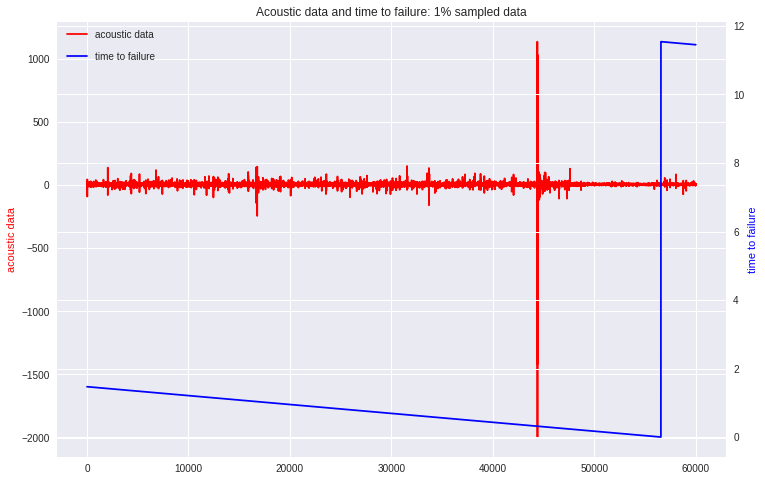

In [0]:
#visulaize 1% of sample data, first 100 datapoints
train_ad_sample_df=train['acoustic_data'].values[::100]
train_ttf_sample_df=train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

**FEATURE ENGINEERING**

In [0]:
#Feature Engineering and significance of these statistical feature

#lets create a function to generate some statistical features 

def gen_features(X):
  strain=[]
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  return pd.Series(strain)


In [0]:
train=pd.read_csv('train.csv',iterator=True,chunksize=150_000,dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

X_train=pd.DataFrame()
y_train=pd.Series()

for df in train:
  ch=gen_features(df['acoustic_data'])
  X_train=X_train.append(ch,ignore_index=True)
  y_train=y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
X_train.head(10)

,0,1,2,3,4,5
0,4.884113,5.101106,-98.0,33.662481,-0.024061,-8.0
1,4.725767,6.588824,-154.0,98.758517,0.390561,-11.0
2,4.906393,6.967397,-106.0,33.555211,0.217391,-15.0
3,4.902240,6.922305,-199.0,116.548172,0.757278,-12.0
4,4.908720,7.301110,-126.0,52.977905,0.064531,-15.0
5,4.913513,5.434111,-144.0,50.215147,-0.100697,-10.0
6,4.855660,5.687823,-78.0,23.173004,0.208810,-12.0
7,4.505427,5.854512,-134.0,52.388738,-0.176333,-11.0
8,4.717833,7.789643,-156.0,65.360261,-0.160166,-16.0
9,4.730960,6.890459,-126.0,53.760207,0.150779,-14.0


In [0]:
y_train.describe()

count    4195.000000
mean        5.683670
std         3.673246
min         0.006398
25%         2.635348
50%         5.358796
75%         8.177500
max        16.103195
dtype: float64

**IMPLEMENT GRADIENT BOOSTING**

In [0]:
#Model-1 -> Catboost
train_pool=Pool(X_train,y_train)
m=CatBoostRegressor(iterations=10000,loss_function='MAE',boosting_type='Ordered')
m.fit(X_train,y_train,silent=False)
m.best_score_

In [0]:
m.best_score_

{'learn': {'MAE': 1.8601300851030422}}

**Implement Support Vector Machine +
Radial Basis Function Kernel**

In [0]:
#Model-2 -> Support Vector Machine w/ RBF + Grid Search
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

In [0]:
!ls

In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [0]:
submission.head(10)

In [0]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [0]:
X_test.head(10)

In [0]:
from scipy.stats import kurtosis

In [0]:


for seg_id in X_test.index:
    seg = pd.read_csv(seg_id + '.csv')
    
    x = seg['acoustic_data']
#     print(x)
#     break
#     ch=gen_features(df['acoustic_data'])
#     X_test=X_train.append(ch,ignore_index=True)
#     y_train=y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    X_test.loc[seg_id, 0] = x.mean()
    X_test.loc[seg_id, 1] = x.std()
    X_test.loc[seg_id, 2] = x.min()
    X_test.loc[seg_id, 3] = x.kurtosis()
    X_test.loc[seg_id, 4] = x.skew()
    X_test.loc[seg_id, 5] = np.quantile(x,0.01)

In [0]:
X_test.head(10)

,0,1,2,3,4,5
seg_id,,,,,,
seg_00030f,4.491780,4.893690,-75.0,28.837568,0.327908,-8.0
seg_0012b5,4.171153,5.922839,-140.0,56.218955,0.295708,-12.0
seg_00184e,4.610260,6.946990,-193.0,162.118284,0.428688,-11.0
seg_003339,4.531473,4.114147,-93.0,41.241827,0.061889,-5.0
seg_0042cc,4.128340,5.797164,-147.0,79.539708,0.073898,-10.0
seg_004314,4.148607,24.782769,-675.0,159.651642,1.016361,-52.0
seg_004cd2,4.113987,4.707150,-107.0,57.044041,0.081861,-7.0
seg_004ee5,4.328380,5.964443,-120.0,35.504290,0.161541,-13.0
seg_004f1f,4.000733,5.874469,-114.0,37.260235,-0.007195,-12.0


In [0]:
submission['time_to_failure'] = m.predict(X_test)
submission.to_csv('submission.csv')

In [0]:
!ls

In [0]:
from google.colab import files
files.download('submission.csv') 

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_test=scaler.transform(X_test)
submission['time_to_failure'] = m.predict(X_test)
submission.to_csv('submission1.csv')

In [0]:
from google.colab import files
files.download('submission1.csv') 